In [1]:
import os
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from mmseq2 import run_mmseqs2
from utils import sample_allocation

# Set random seed for reproducibility
np.random.seed(42)

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_parquet("combined_df_with_ss.parquet")

In [3]:
# Extract valid sequences
df_valid = df[df.agg_confidence > 0.6].copy()
df_valid["monomer_seq"] = df_valid.seq.apply(lambda x: x.split("/")[0])
print(len(df_valid))

577361


In [4]:
# Run MM_seq for each symmetry group and add results to dataframe
for sym in tqdm(df_valid.symmetry.unique()):
    seqs = df_valid[df_valid.symmetry == sym]["monomer_seq"].tolist()
    print(f"Running MMseqs2 for symmetry {sym} with {len(seqs)} sequences")
    df_mmseqs = run_mmseqs2(seqs, os.path.join("mmseqs2_outputs", f"mmseqs2_output_{sym}"), threads=8, sensitivity=7.5)

    # Match based on sequence content
    seq_to_cluster = dict(zip(df_mmseqs.seq, df_mmseqs.cluster_id))
    seq_to_cluster_size = dict(zip(df_mmseqs.seq, df_mmseqs.cluster_size))

    mask = df_valid.symmetry == sym
    df_valid.loc[mask, "mmseqs_cluster_id"] = df_valid.loc[mask, "monomer_seq"].map(seq_to_cluster)
    df_valid.loc[mask, "mmseqs_cluster_size"] = df_valid.loc[mask, "monomer_seq"].map(seq_to_cluster_size)


  0%|          | 0/12 [00:00<?, ?it/s]

Running MMseqs2 for symmetry C4 with 163527 sequences
easy-cluster mmseqs2_outputs/mmseqs2_output_C4/input.fasta mmseqs2_outputs/mmseqs2_output_C4/output mmseqs2_outputs/mmseqs2_output_C4/tmp --min-seq-id 0.5 --threads 8 -s 7.5 

MMseqs Version:                     	18.8cc5c
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	7.5
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias scale

In [5]:
# Print MMseqs2 summary for all symmetry groups
print("\nSummary for all symmetry groups:")
for sym in df_valid.symmetry.unique():
    mask = df_valid.symmetry == sym
    print(f"Symmetry: {sym}; # Clusters: {df_valid.loc[mask, 'mmseqs_cluster_id'].nunique()}; # Samples: {mask.sum()}")


Summary for all symmetry groups:
Symmetry: C4; # Clusters: 4432; # Samples: 163527
Symmetry: C8; # Clusters: 1080; # Samples: 19052
Symmetry: C6; # Clusters: 2189; # Samples: 47254
Symmetry: C3; # Clusters: 4923; # Samples: 187132
Symmetry: C9; # Clusters: 943; # Samples: 16478
Symmetry: C10; # Clusters: 286; # Samples: 5179
Symmetry: C5; # Clusters: 2970; # Samples: 75453
Symmetry: D2; # Clusters: 922; # Samples: 29430
Symmetry: D4; # Clusters: 51; # Samples: 602
Symmetry: D3; # Clusters: 241; # Samples: 5092
Symmetry: C7; # Clusters: 1335; # Samples: 27937
Symmetry: D5; # Clusters: 17; # Samples: 225
Symmetry: C5; # Clusters: 2970; # Samples: 75453
Symmetry: D2; # Clusters: 922; # Samples: 29430
Symmetry: D4; # Clusters: 51; # Samples: 602
Symmetry: D3; # Clusters: 241; # Samples: 5092
Symmetry: C7; # Clusters: 1335; # Samples: 27937
Symmetry: D5; # Clusters: 17; # Samples: 225


In [ ]:
# Define number of bins for each secondary structure feature
n_bins = 10

# Create bins for helix, strand, and coil ratios
df_valid["ss_helix_bin"] = pd.cut(df_valid["ss_helix_ratio"], bins=n_bins, labels=False)
df_valid["ss_strand_bin"] = pd.cut(df_valid["ss_strand_ratio"], bins=n_bins, labels=False)
df_valid["ss_coil_bin"] = pd.cut(df_valid["ss_coil_ratio"], bins=n_bins, labels=False)

# Create a combined secondary structure bin identifier
df_valid["ss_bin"] = (
    df_valid["ss_helix_bin"].astype(str)
    + "_"
    + df_valid["ss_strand_bin"].astype(str)
    + "_"
    + df_valid["ss_coil_bin"].astype(str)
)

print(f"Created {n_bins} bins for each secondary structure feature")
print(f"Total unique SS combinations: {df_valid['ss_bin'].nunique()}")

# Show distribution of SS bins per symmetry
print("\nSS bin distribution per symmetry:")
for sym in df_valid["symmetry"].unique():
    sym_data = df_valid[df_valid["symmetry"] == sym]
    print(f"{sym}: {sym_data['ss_bin'].nunique()} unique SS bins out of {len(sym_data)} sequences")


Created 10 bins for each secondary structure feature
Total unique SS combinations: 113

SS bin distribution per symmetry:
C4: 101 unique SS bins out of 163527 sequences
C8: 47 unique SS bins out of 19052 sequences
C6: 59 unique SS bins out of 47254 sequences
C3: 104 unique SS bins out of 187132 sequences
C9: 35 unique SS bins out of 16478 sequences
C10: 22 unique SS bins out of 5179 sequences
C5: 75 unique SS bins out of 75453 sequences
D2: 89 unique SS bins out of 29430 sequences
D4: 12 unique SS bins out of 602 sequences
D3: 51 unique SS bins out of 5092 sequences
C7: 43 unique SS bins out of 27937 sequences
D5: 5 unique SS bins out of 225 sequences


In [29]:
# Compute number of target samples per symmetry group
target_size = 10000
samples_per_symmetry = sample_allocation(
    df=df_valid, group_keys=["symmetry"], n_samples=target_size, return_allocation_only=True
)

print(f"Target: {target_size}, Allocated: {sum(samples_per_symmetry.values())}")
print("Samples per symmetry:")
for sym, count in samples_per_symmetry.items():
    print(f"{sym}: {count}")

Number of groups: 12
Target: 10000, Allocated: 10000
Samples per symmetry:
C10: 918
C3: 918
C4: 918
C5: 917
C6: 917
C7: 917
C8: 917
C9: 917
D2: 917
D3: 917
D4: 602
D5: 225


In [30]:
# Make the sequence selection for each symmetry group (could also be combined with symmetry sampling, but I like this more)

random_percentage = 0.1  # 10% random selection of sequences per symmetry group

selected_indices = []
for sym, target_count in samples_per_symmetry.items():
    sym_data = df_valid[df_valid["symmetry"] == sym]
    print(f"\nSelecting for symmetry {sym} with target count {target_count} from {len(sym_data)} sequences")

    # First, select a random subset of sequences
    n_random = int(target_count * random_percentage)
    random_indices = sym_data.sample(n=n_random, random_state=42).index.tolist()
    selected_indices.extend(random_indices)
    print(f"  Selected {n_random} random sequences")

    # Remaining sequences to select based on cluster and SS bin diversity
    remaining_count = target_count - n_random

    # Remove randomly selected sequences from consideration for diverse sampling
    remaining_sym_data = sym_data.drop(random_indices)

    # Step 1: Sample uniformly across SS bins FIRST
    ss_allocation = sample_allocation(
        df=remaining_sym_data,
        group_keys=["ss_bin"],  # Only SS bins, not clusters
        n_samples=remaining_count,
        return_allocation_only=True,
    )

    print(f"Starting SS bin allocation")

    # Step 2: Within each SS bin, sample across clusters
    for ss_bin, n_for_bin in ss_allocation.items():
        bin_data = remaining_sym_data[remaining_sym_data.ss_bin == ss_bin]
        cluster_indices = sample_allocation(
            df=bin_data,
            group_keys=["mmseqs_cluster_id"],  # Only clusters within this SS bin
            n_samples=n_for_bin,
            return_allocation_only=False,
        )
        selected_indices.extend(cluster_indices)

    print(f"  Selected {len(random_indices)} random + {len(selected_indices) - len(random_indices)} diverse sequences")



Selecting for symmetry C10 with target count 918 from 5179 sequences
  Selected 91 random sequences
Number of groups: 10
Starting SS bin allocation
Number of groups: 2
Number of groups: 2
Number of groups: 1
Number of groups: 3
Number of groups: 1
Number of groups: 8
Number of groups: 39
Number of groups: 1
Number of groups: 271
Number of groups: 9
  Selected 91 random + 827 diverse sequences

Selecting for symmetry C3 with target count 918 from 187132 sequences
  Selected 91 random sequences
Number of groups: 30
Starting SS bin allocation
Number of groups: 10
Number of groups: 4
Number of groups: 2
Number of groups: 20
Number of groups: 7
Number of groups: 5
Number of groups: 12
Number of groups: 11
Number of groups: 2
Number of groups: 212
Number of groups: 67
Number of groups: 63
Number of groups: 238
Number of groups: 8
Number of groups: 25
Number of groups: 24
Number of groups: 187
Number of groups: 77
Number of groups: 238
Number of groups: 603
Number of groups: 4
Number of grou

In [24]:
print(f"Selected {len(selected_indices)} sequences!")

df_out = df_valid.loc[selected_indices].reset_index(drop=True)

df_out.to_parquet("df_out.parquet")

Selected 10000 sequences!


In [25]:
df_out.head()

,seq,seq_name,seq_file,backbone_file,boltz_output_file,confidence_score,complex_plddt,complex_iplddt,complex_ipde,pmpnn_description,...,ss_helix_ratio,ss_strand_ratio,ss_coil_ratio,monomer_seq,mmseqs_cluster_id,mmseqs_cluster_size,ss_helix_bin,ss_strand_bin,ss_coil_bin,ss_bin
0,GEYEKAQAYLELAKAYSQAPASFAALGVEYAEKALKYAKKAGEKVG...,sample_13_length_460_seq_1,sample_13_length_460.fa,sample_13_length_460.pdb,/homefs/home/hetzell/code/sym-protein-val/data...,[0.832912623882293],[0.85383129119873],[0.85383129119873],[0.0],"T=0.15, sample=2, score=0.5601, global_score=0...",...,0.869565,0.0,0.130435,GEYEKAQAYLELAKAYSQAPASFAALGVEYAEKALKYAKKAGEKVG...,seq40,80.0,17,0,2,17_0_2
1,KEEEEKKKKELEEKYKEIIKKLEEFAKTVSGEKKTEIQLEIIKLEK...,sample_18_length_530_seq_3,sample_18_length_530.fa,sample_18_length_530.pdb,/homefs/home/hetzell/code/sym-protein-val/data...,"[0.611668527126312, 0.611668527126312, 0.61166...","[0.699920415878295, 0.699920415878295, 0.69992...","[0.6724858283996581, 0.6724858283996581, 0.672...","[12.83531379699707, 12.83531379699707, 12.8353...","T=0.15, sample=4, score=0.5184, global_score=0...",...,0.867925,0.0,0.132075,KEEEEKKKKELEEKYKEIIKKLEEFAKTVSGEKKTEIQLEIIKLEK...,seq28,35.0,17,0,2,17_0_2
2,MIGKEAAKGWAEVFLKDPEAAKALAEFLAQTARKKAEEIAIEAVKI...,sample_19_length_540_seq_1,sample_19_length_540.fa,sample_19_length_540.pdb,/homefs/home/hetzell/code/sym-protein-val/data...,"[0.6134648323059081, 0.6134648323059081, 0.613...","[0.685749053955078, 0.685749053955078, 0.68574...","[0.6802936792373651, 0.6802936792373651, 0.680...","[11.410144805908203, 11.410144805908203, 11.41...","T=0.15, sample=2, score=0.5664, global_score=0...",...,0.851852,0.0,0.148148,MIGKEAAKGWAEVFLKDPEAAKALAEFLAQTARKKAEEIAIEAVKI...,seq877,2.0,17,0,2,17_0_2
3,EVAVEAAKEAADLYKHLMTLETLSEKQLEEARAAALAAIAAMKEA/...,sample_19_length_450_seq_3,sample_19_length_450.fa,sample_19_length_450.pdb,/homefs/home/hetzell/code/sym-protein-val/data...,"[0.6595968604087831, 0.6595968604087831, 0.659...","[0.743764996528625, 0.743764996528625, 0.74376...","[0.7372494935989381, 0.7372494935989381, 0.737...","[9.264625549316406, 9.264625549316406, 9.26462...","T=0.15, sample=4, score=0.4361, global_score=0...",...,0.822222,0.0,0.177778,EVAVEAAKEAADLYKHLMTLETLSEKQLEEARAAALAAIAAMKEA,seq4231,20.0,16,0,3,16_0_3
4,SIKKQGEELGEKKGELELYKWALELTKFIITKDEITEEAIRKAMEN...,sample_1_length_790_seq_7,sample_1_length_790.fa,sample_1_length_790.pdb,/homefs/home/hetzell/code/sym-protein-val/data...,"[0.729505836963653, 0.729505836963653, 0.72950...","[0.8014588356018061, 0.8014588356018061, 0.801...","[0.7958294749259941, 0.7958294749259941, 0.795...","[11.206917762756348, 11.206917762756348, 11.20...","T=0.15, sample=8, score=0.6963, global_score=0...",...,0.860759,0.0,0.139241,SIKKQGEELGEKKGELELYKWALELTKFIITKDEITEEAIRKAMEN...,seq4159,5.0,17,0,2,17_0_2


Original C3: 10000 sequences
Selected C3: 918 sequences


/Users/larspennig/anaconda3/envs/seq_extract/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/larspennig/anaconda3/envs/seq_extract/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/larspennig/anaconda3/envs/seq_extract/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


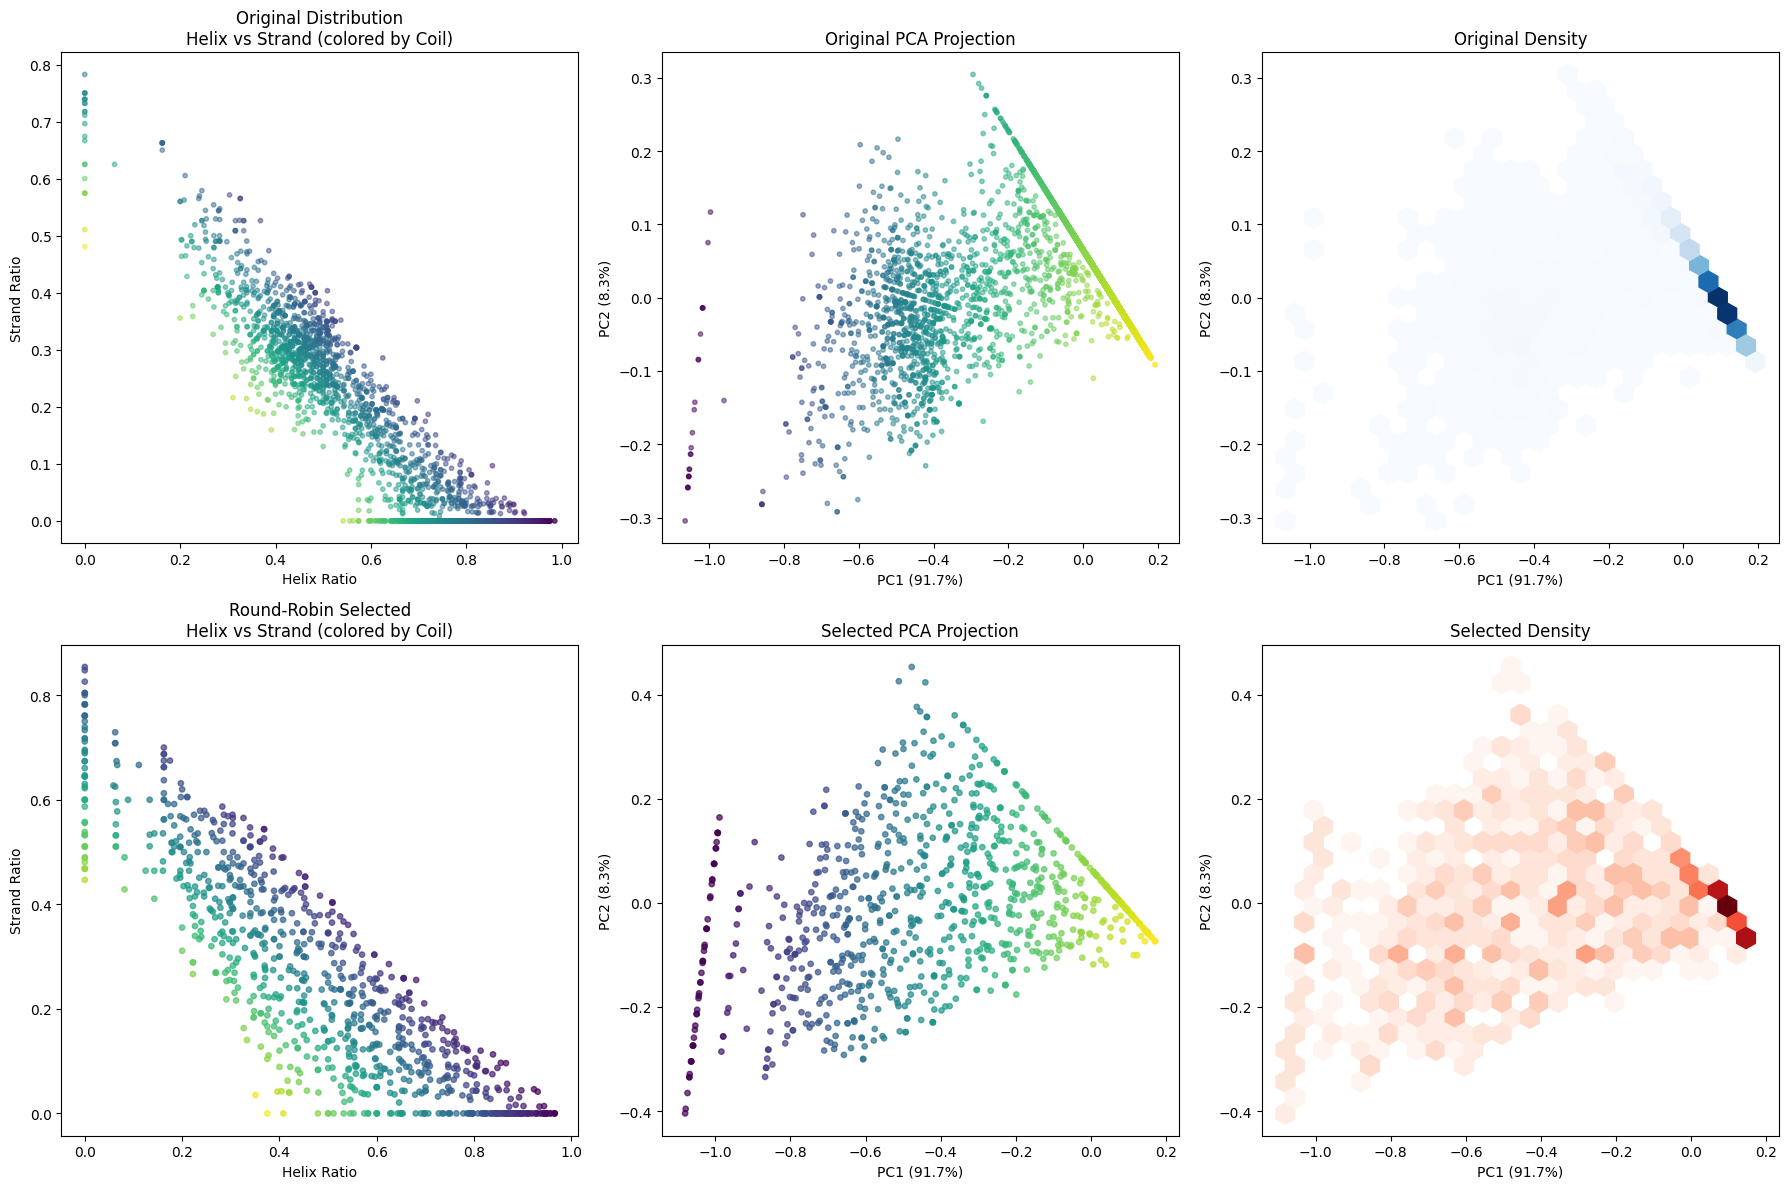


Standard Deviation Statistics Comparison for C3:
Metric               Original        Selected        Change
------------------------------------------------------------
ss_helix_ratio       0.1592          0.2478          +55.6%
ss_strand_ratio      0.1084          0.2066          +90.6%
ss_coil_ratio        0.0731          0.1203          +64.6%


In [35]:
# Compare original vs selected distributions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

sym = "C3"
original_data = df_valid[df_valid["symmetry"] == sym].sample(n=10000, random_state=42)
selected_data = df_out[df_out["symmetry"] == sym]

print(f"Original {sym}: {len(original_data)} sequences")
print(f"Selected {sym}: {len(selected_data)} sequences")

# Create comparison figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# PCA for both datasets
ss_features_orig = original_data[["ss_helix_ratio", "ss_strand_ratio", "ss_coil_ratio"]].values
ss_features_sel = selected_data[["ss_helix_ratio", "ss_strand_ratio", "ss_coil_ratio"]].values

pca = PCA(n_components=2)
pca.fit(ss_features_orig)  # Fit on original to maintain same coordinate system
ss_pca_orig = pca.transform(ss_features_orig)
ss_pca_sel = pca.transform(ss_features_sel)

# Row 1: Original distribution
axes[0, 0].scatter(
    original_data["ss_helix_ratio"],
    original_data["ss_strand_ratio"],
    c=original_data["ss_coil_ratio"],
    cmap="viridis",
    alpha=0.5,
    s=10,
)
axes[0, 0].set_xlabel("Helix Ratio")
axes[0, 0].set_ylabel("Strand Ratio")
axes[0, 0].set_title(f"Original Distribution\nHelix vs Strand (colored by Coil)")

axes[0, 1].scatter(
    ss_pca_orig[:, 0], ss_pca_orig[:, 1], c=original_data["ss_helix_ratio"], cmap="viridis", alpha=0.5, s=10
)
axes[0, 1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[0, 1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[0, 1].set_title("Original PCA Projection")

axes[0, 2].hexbin(ss_pca_orig[:, 0], ss_pca_orig[:, 1], gridsize=25, cmap="Blues", mincnt=1)
axes[0, 2].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[0, 2].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[0, 2].set_title("Original Density")

# Row 2: Selected distribution
axes[1, 0].scatter(
    selected_data["ss_helix_ratio"],
    selected_data["ss_strand_ratio"],
    c=selected_data["ss_coil_ratio"],
    cmap="viridis",
    alpha=0.7,
    s=15,
)
axes[1, 0].set_xlabel("Helix Ratio")
axes[1, 0].set_ylabel("Strand Ratio")
axes[1, 0].set_title(f"Round-Robin Selected\nHelix vs Strand (colored by Coil)")

axes[1, 1].scatter(
    ss_pca_sel[:, 0], ss_pca_sel[:, 1], c=selected_data["ss_helix_ratio"], cmap="viridis", alpha=0.7, s=15
)
axes[1, 1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[1, 1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[1, 1].set_title("Selected PCA Projection")

axes[1, 2].hexbin(ss_pca_sel[:, 0], ss_pca_sel[:, 1], gridsize=25, cmap="Reds", mincnt=1)
axes[1, 2].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[1, 2].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[1, 2].set_title("Selected Density")

plt.tight_layout()
plt.show()

# Quantitative comparison
print(f"\nStandard Deviation Statistics Comparison for {sym}:")
print(f"{'Metric':<20} {'Original':<15} {'Selected':<15} {'Change'}")
print("-" * 60)

for feature in ["ss_helix_ratio", "ss_strand_ratio", "ss_coil_ratio"]:
    orig_std = original_data[feature].std()
    sel_std = selected_data[feature].std()
    change = (sel_std - orig_std) / orig_std * 100
    print(f"{feature:<20} {orig_std:<15.4f} {sel_std:<15.4f} {change:+.1f}%")